In [1]:
%matplotlib inline

# Filtering

Operations looking to remove compounds from a collection are implemented as `Filter`s in **scikit-chem**.  These are implemented in the `skchem.filters` packages:

In [19]:
skchem.filters.__all__

['ChiralFilter',
 'SMARTSFilter',
 'PAINSFilter',
 'ElementFilter',
 'OrganicFilter',
 'AtomNumberFilter',
 'MassFilter',
 'Filter']

They are used very much like `Transformer`s:

In [20]:
of = skchem.filters.OrganicFilter()

In [21]:
benzene = skchem.Mol.from_smiles('c1ccccc1', name='benzene')
ferrocene = skchem.Mol.from_smiles('[cH-]1cccc1.[cH-]1cccc1.[Fe+2]', name='ferrocene')
norbornane = skchem.Mol.from_smiles('C12CCC(C2)CC1', name='norbornane')
dicyclopentadiene = skchem.Mol.from_smiles('C1C=CC2C1C3CC2C=C3')
ms = [benzene, ferrocene, norbornane, dicyclopentadiene]

In [22]:
of.filter(ms)

OrganicFilter: 100% (4 of 4) |#################################################| Elapsed Time: 0:00:00 Time: 0:00:00


benzene                   <Mol: c1ccccc1>
norbornane             <Mol: C1CC2CCC1C2>
3             <Mol: C1=CC2C3C=CC(C3)C2C1>
Name: structure, dtype: object

`Filter`s essentially use a *predicate* function to decide whether to keep or remove instances.  The result of this function can be returned using `transform`:

In [23]:
of.transform(ms)

OrganicFilter: 100% (4 of 4) |#################################################| Elapsed Time: 0:00:00 Time: 0:00:00


benzene        True
ferrocene     False
norbornane     True
3              True
dtype: bool

### Filters are Transformers

As `Filter`s have a transform method, they are themselves `Transformer`s, that transform a molecule into the result of the predicate!

In [24]:
issubclass(skchem.filters.Filter, skchem.base.Transformer)

True

The predicate functions should return `None`, `False` or `np.nan` for negative results, and anything else for positive results

## Creating your own Filter

You can create your own filter by passing a predicate function to the `Filter` class.  For example, perhaps you only wanted compounds to keep compounds that had a name:

In [25]:
is_named = skchem.filters.Filter(lambda m: m.name is not None)

We carelessly did not set dicyclopentadiene's name previously, so we want this to get filtered out:

In [26]:
is_named.filter(ms)

Filter: 100% (4 of 4) |########################################################| Elapsed Time: 0:00:00 Time: 0:00:00


benzene                             <Mol: c1ccccc1>
ferrocene     <Mol: [Fe+2].c1cc[cH-]c1.c1cc[cH-]c1>
norbornane                       <Mol: C1CC2CCC1C2>
Name: structure, dtype: object

It worked!

## Transforming and Filtering

A common functionality in cheminformatics is to convert a molecule into *something else*, and if the conversion fails, to just remove the compound.  An example of this is **standardization**, where one might want to throw away compounds that fail to standardize, or **geometry optimization** where one might throw away molecules that fail to converge.

This functionality is similar to but crucially **different from simply `filtering`**, as filtering returns the original compounds, rather than the transformed compounds.  Instead, there are special `Filter`s, called `TransformFilter`s, that can perform this task in a single method call. To give an example of the functionality, we will use the `UFF` class:

In [27]:
issubclass(skchem.forcefields.UFF, skchem.filters.base.TransformFilter)

True

They are instanciated the same way as normal `Transformers` and `Filter`s:

In [28]:
uff = skchem.forcefields.UFF()

An example molecule that fails is taken from the NCI DTP Diversity set III:

In [29]:
mol_that_fails = skchem.Mol.from_smiles('C[C@H](CCC(=O)O)[C@H]1CC[C@@]2(C)[C@@H]3C(=O)C[C@H]4C(C)(C)[C@@H](O)CC[C@]4(C)[C@H]3C(=O)C[C@]12C', 
                                        name='7524')

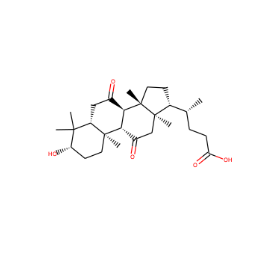

In [30]:
skchem.vis.draw(mol_that_fails)

In [31]:
ms.append(mol_that_fails)

In [32]:
res = uff.filter(ms); res

/Users/rich/projects/scikit-chem/skchem/forcefields/base.py:54: UserWarning: Failed to Embed Molecule 7524
  warnings.warn(msg)
UFF: 100% (5 of 5) |###########################################################| Elapsed Time: 0:00:01 Time: 0:00:01


benzene                             <Mol: c1ccccc1>
ferrocene     <Mol: [Fe+2].c1cc[cH-]c1.c1cc[cH-]c1>
norbornane                       <Mol: C1CC2CCC1C2>
3                       <Mol: C1=CC2C3C=CC(C3)C2C1>
Name: structure, dtype: object

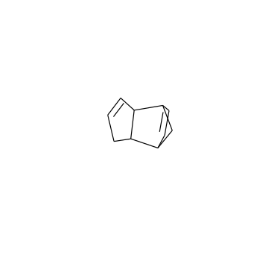

In [33]:
skchem.vis.draw(res.ix[3])

In [34]:
res = uff.transform_filter(ms); res

/Users/rich/projects/scikit-chem/skchem/forcefields/base.py:54: UserWarning: Failed to Embed Molecule 7524
  warnings.warn(msg)
UFF: 100% (5 of 5) |###########################################################| Elapsed Time: 0:00:01 Time: 0:00:01


benzene               <Mol: [H]c1c([H])c([H])c([H])c([H])c1[H]>
ferrocene     <Mol: [Fe+2].[H]c1c([H])c([H])[c-]([H])c1[H].[...
norbornane    <Mol: [H]C1([H])C([H])([H])C2([H])C([H])([H])C...
3             <Mol: [H]C1=C([H])C2([H])C3([H])C([H])=C([H])C...
Name: structure, dtype: object

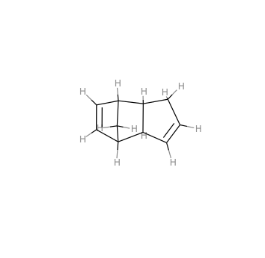

In [35]:
skchem.vis.draw(res.ix[3])